# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '../../../../Downloads/data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

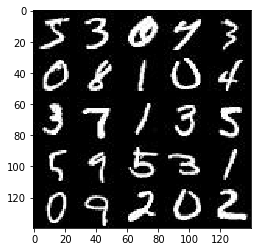

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

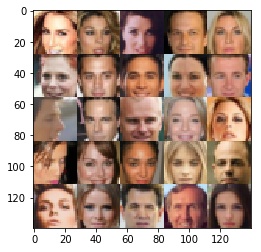

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='real_images')
    z_data = tf.placeholder(tf.float32, shape = [None, z_dim], name='z_data')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1)
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 3, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 3, strides=2, padding='valid')
        x3 = tf.layers.batch_normalization(x3)
        x3 = tf.maximum(alpha * x3, x3)
        # 3x3x256
        
        flat = tf.reshape(x3, (-1, 3*3*256) )
        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 3x3x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='valid')  # valid -> size: 2 * 3 + 1
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now

        x3 = tf.layers.conv2d_transpose(x2, 256, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x256 now
        
        
        # Output layer, 32x32xout_channel_dim
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    
    # generator 
    g_model = generator(input_z, out_channel_dim, is_train=True)
    # discriminator
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, _ = model_inputs(*data_shape[1:4], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_i = 0
            for batch_images in get_batches(batch_size):
                batch_i += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
               # _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                # show stats every 10 batches
                if batch_i % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                # show images every 100 batches
                if batch_i % 100 == 0:
                    show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                    
            # end of Epoch images
            print('State of the art after epoch', epoch_i+1)
            show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                 
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2988... Generator Loss: 0.6145
Epoch 1/2... Discriminator Loss: 1.3727... Generator Loss: 0.6901
Epoch 1/2... Discriminator Loss: 1.4477... Generator Loss: 0.7747
Epoch 1/2... Discriminator Loss: 1.2768... Generator Loss: 0.9481
Epoch 1/2... Discriminator Loss: 1.4547... Generator Loss: 0.6997
Epoch 1/2... Discriminator Loss: 1.2015... Generator Loss: 0.8752
Epoch 1/2... Discriminator Loss: 1.2263... Generator Loss: 0.8315
Epoch 1/2... Discriminator Loss: 1.3317... Generator Loss: 0.8138
Epoch 1/2... Discriminator Loss: 1.3450... Generator Loss: 0.8219
Epoch 1/2... Discriminator Loss: 1.4749... Generator Loss: 0.7392


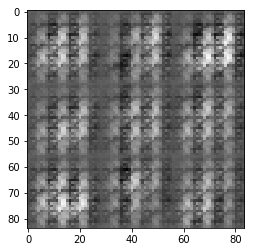

Epoch 1/2... Discriminator Loss: 1.2444... Generator Loss: 0.8951
Epoch 1/2... Discriminator Loss: 1.4819... Generator Loss: 0.6957
Epoch 1/2... Discriminator Loss: 1.2278... Generator Loss: 0.9829
Epoch 1/2... Discriminator Loss: 1.3676... Generator Loss: 0.8160
Epoch 1/2... Discriminator Loss: 1.2763... Generator Loss: 0.8888
Epoch 1/2... Discriminator Loss: 1.4050... Generator Loss: 0.7211
Epoch 1/2... Discriminator Loss: 1.3499... Generator Loss: 0.8071
Epoch 1/2... Discriminator Loss: 1.2012... Generator Loss: 0.9319
Epoch 1/2... Discriminator Loss: 1.3695... Generator Loss: 0.8103
Epoch 1/2... Discriminator Loss: 1.3076... Generator Loss: 0.8351


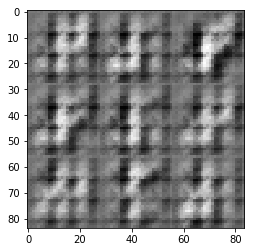

Epoch 1/2... Discriminator Loss: 1.2681... Generator Loss: 0.8192
Epoch 1/2... Discriminator Loss: 1.2262... Generator Loss: 0.8952
Epoch 1/2... Discriminator Loss: 1.1931... Generator Loss: 1.0303
Epoch 1/2... Discriminator Loss: 1.2431... Generator Loss: 0.8574
Epoch 1/2... Discriminator Loss: 1.2962... Generator Loss: 0.8883
Epoch 1/2... Discriminator Loss: 1.6456... Generator Loss: 0.6729
Epoch 1/2... Discriminator Loss: 1.1912... Generator Loss: 0.9347
Epoch 1/2... Discriminator Loss: 1.4454... Generator Loss: 0.7265
Epoch 1/2... Discriminator Loss: 1.0083... Generator Loss: 1.0707
Epoch 1/2... Discriminator Loss: 1.2301... Generator Loss: 0.9104


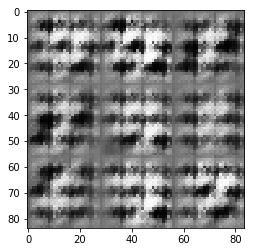

Epoch 1/2... Discriminator Loss: 1.5361... Generator Loss: 0.7835
Epoch 1/2... Discriminator Loss: 1.1501... Generator Loss: 0.9584
Epoch 1/2... Discriminator Loss: 1.1610... Generator Loss: 0.9931
Epoch 1/2... Discriminator Loss: 1.2084... Generator Loss: 0.9828
Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 0.8180
Epoch 1/2... Discriminator Loss: 1.3521... Generator Loss: 0.8362
Epoch 1/2... Discriminator Loss: 1.2538... Generator Loss: 0.8814
Epoch 1/2... Discriminator Loss: 1.3444... Generator Loss: 0.8064
Epoch 1/2... Discriminator Loss: 1.2142... Generator Loss: 0.9344
Epoch 1/2... Discriminator Loss: 0.9218... Generator Loss: 1.2353


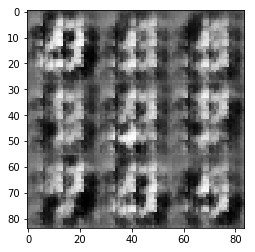

Epoch 1/2... Discriminator Loss: 1.3790... Generator Loss: 0.8071
Epoch 1/2... Discriminator Loss: 1.0865... Generator Loss: 1.1407
Epoch 1/2... Discriminator Loss: 1.5026... Generator Loss: 0.7235
Epoch 1/2... Discriminator Loss: 1.1824... Generator Loss: 0.9704
Epoch 1/2... Discriminator Loss: 1.1354... Generator Loss: 0.9460
Epoch 1/2... Discriminator Loss: 1.1617... Generator Loss: 1.0375
Epoch 1/2... Discriminator Loss: 1.5429... Generator Loss: 0.7449
Epoch 1/2... Discriminator Loss: 1.0787... Generator Loss: 1.0862
Epoch 1/2... Discriminator Loss: 1.3738... Generator Loss: 0.8133
Epoch 1/2... Discriminator Loss: 1.2409... Generator Loss: 0.8884


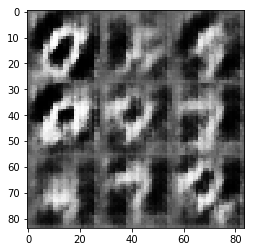

Epoch 1/2... Discriminator Loss: 1.2838... Generator Loss: 0.8741
Epoch 1/2... Discriminator Loss: 1.1669... Generator Loss: 0.9462
Epoch 1/2... Discriminator Loss: 1.1890... Generator Loss: 0.9063
Epoch 1/2... Discriminator Loss: 1.3876... Generator Loss: 0.8518
Epoch 1/2... Discriminator Loss: 1.3213... Generator Loss: 0.8486
Epoch 1/2... Discriminator Loss: 1.3369... Generator Loss: 0.9044
Epoch 1/2... Discriminator Loss: 1.2852... Generator Loss: 0.8460
Epoch 1/2... Discriminator Loss: 1.3844... Generator Loss: 0.7693
Epoch 1/2... Discriminator Loss: 1.1961... Generator Loss: 0.9228
Epoch 1/2... Discriminator Loss: 1.2696... Generator Loss: 0.8305


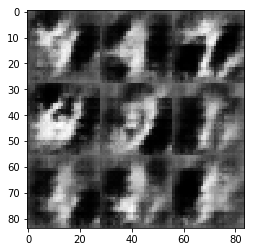

Epoch 1/2... Discriminator Loss: 1.1759... Generator Loss: 0.9827
Epoch 1/2... Discriminator Loss: 1.2989... Generator Loss: 0.8470
Epoch 1/2... Discriminator Loss: 1.2793... Generator Loss: 0.9291
Epoch 1/2... Discriminator Loss: 1.0952... Generator Loss: 1.0409
Epoch 1/2... Discriminator Loss: 1.3667... Generator Loss: 0.8027
Epoch 1/2... Discriminator Loss: 1.3083... Generator Loss: 0.8760
Epoch 1/2... Discriminator Loss: 1.0580... Generator Loss: 1.0192
Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 0.7834
Epoch 1/2... Discriminator Loss: 1.4106... Generator Loss: 0.7925
Epoch 1/2... Discriminator Loss: 1.1171... Generator Loss: 1.0945


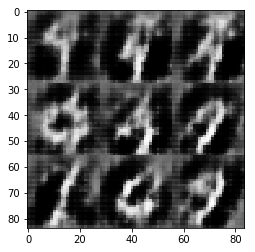

Epoch 1/2... Discriminator Loss: 1.3434... Generator Loss: 0.9083
Epoch 1/2... Discriminator Loss: 1.1570... Generator Loss: 0.9820
Epoch 1/2... Discriminator Loss: 1.2943... Generator Loss: 0.9379
Epoch 1/2... Discriminator Loss: 1.2546... Generator Loss: 0.9037
Epoch 1/2... Discriminator Loss: 1.2111... Generator Loss: 0.8788
Epoch 1/2... Discriminator Loss: 1.4691... Generator Loss: 0.8019
Epoch 1/2... Discriminator Loss: 1.2507... Generator Loss: 0.9742
Epoch 1/2... Discriminator Loss: 1.3167... Generator Loss: 0.9066
Epoch 1/2... Discriminator Loss: 1.1700... Generator Loss: 0.9760
Epoch 1/2... Discriminator Loss: 1.1827... Generator Loss: 0.8561


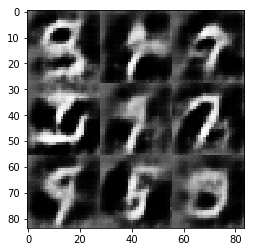

Epoch 1/2... Discriminator Loss: 1.3067... Generator Loss: 0.8046
Epoch 1/2... Discriminator Loss: 1.1891... Generator Loss: 0.9652
Epoch 1/2... Discriminator Loss: 1.5670... Generator Loss: 0.6788
Epoch 1/2... Discriminator Loss: 1.3021... Generator Loss: 0.8607
Epoch 1/2... Discriminator Loss: 1.3057... Generator Loss: 0.8466
Epoch 1/2... Discriminator Loss: 1.3694... Generator Loss: 0.7042
Epoch 1/2... Discriminator Loss: 1.3568... Generator Loss: 0.8290
Epoch 1/2... Discriminator Loss: 1.5014... Generator Loss: 0.7697
Epoch 1/2... Discriminator Loss: 1.4176... Generator Loss: 0.6997
Epoch 1/2... Discriminator Loss: 1.2564... Generator Loss: 0.9233


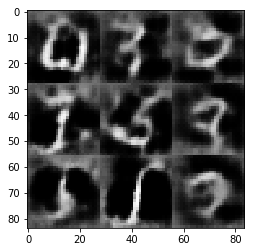

Epoch 1/2... Discriminator Loss: 1.2383... Generator Loss: 0.9571
Epoch 1/2... Discriminator Loss: 1.3639... Generator Loss: 0.8111
Epoch 1/2... Discriminator Loss: 1.5642... Generator Loss: 0.6190
State of the art after epoch 1


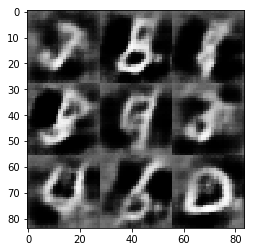

Epoch 2/2... Discriminator Loss: 1.3337... Generator Loss: 0.7534
Epoch 2/2... Discriminator Loss: 1.3346... Generator Loss: 0.7773
Epoch 2/2... Discriminator Loss: 1.3020... Generator Loss: 0.8589
Epoch 2/2... Discriminator Loss: 1.2838... Generator Loss: 0.8954
Epoch 2/2... Discriminator Loss: 1.3698... Generator Loss: 0.8120
Epoch 2/2... Discriminator Loss: 1.2604... Generator Loss: 0.8646
Epoch 2/2... Discriminator Loss: 1.2865... Generator Loss: 0.9199
Epoch 2/2... Discriminator Loss: 1.3083... Generator Loss: 0.7801
Epoch 2/2... Discriminator Loss: 1.4006... Generator Loss: 0.8262
Epoch 2/2... Discriminator Loss: 1.3576... Generator Loss: 0.8308


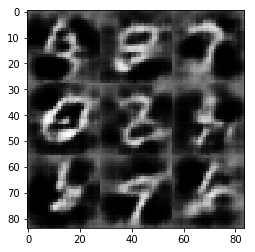

Epoch 2/2... Discriminator Loss: 1.2380... Generator Loss: 0.9257
Epoch 2/2... Discriminator Loss: 1.4461... Generator Loss: 0.7547
Epoch 2/2... Discriminator Loss: 1.3344... Generator Loss: 0.8804
Epoch 2/2... Discriminator Loss: 1.3091... Generator Loss: 0.8969
Epoch 2/2... Discriminator Loss: 1.2575... Generator Loss: 0.8763
Epoch 2/2... Discriminator Loss: 1.3286... Generator Loss: 0.8265
Epoch 2/2... Discriminator Loss: 1.3659... Generator Loss: 0.8847
Epoch 2/2... Discriminator Loss: 1.3092... Generator Loss: 0.8995
Epoch 2/2... Discriminator Loss: 1.2268... Generator Loss: 0.9469
Epoch 2/2... Discriminator Loss: 1.2843... Generator Loss: 0.8381


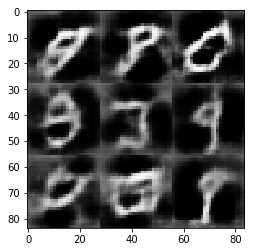

Epoch 2/2... Discriminator Loss: 1.2777... Generator Loss: 0.8476
Epoch 2/2... Discriminator Loss: 1.3965... Generator Loss: 0.8391
Epoch 2/2... Discriminator Loss: 1.2685... Generator Loss: 0.9153
Epoch 2/2... Discriminator Loss: 1.3284... Generator Loss: 0.8453
Epoch 2/2... Discriminator Loss: 1.3173... Generator Loss: 0.8645
Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 0.8403
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 0.7754
Epoch 2/2... Discriminator Loss: 1.2898... Generator Loss: 0.7836
Epoch 2/2... Discriminator Loss: 1.4029... Generator Loss: 0.9316
Epoch 2/2... Discriminator Loss: 1.3136... Generator Loss: 0.7945


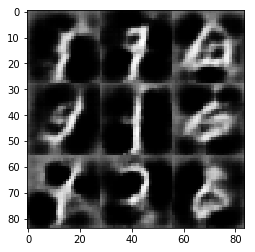

Epoch 2/2... Discriminator Loss: 1.2336... Generator Loss: 1.0133
Epoch 2/2... Discriminator Loss: 1.3527... Generator Loss: 0.8067
Epoch 2/2... Discriminator Loss: 1.3661... Generator Loss: 0.8717
Epoch 2/2... Discriminator Loss: 1.2893... Generator Loss: 0.8112
Epoch 2/2... Discriminator Loss: 1.3583... Generator Loss: 0.7815
Epoch 2/2... Discriminator Loss: 1.2677... Generator Loss: 0.9287
Epoch 2/2... Discriminator Loss: 1.2291... Generator Loss: 0.9275
Epoch 2/2... Discriminator Loss: 1.1714... Generator Loss: 0.9319
Epoch 2/2... Discriminator Loss: 1.2578... Generator Loss: 0.8843
Epoch 2/2... Discriminator Loss: 1.3225... Generator Loss: 0.7868


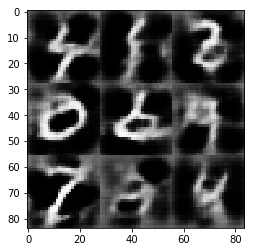

Epoch 2/2... Discriminator Loss: 1.2682... Generator Loss: 0.8546
Epoch 2/2... Discriminator Loss: 1.2999... Generator Loss: 0.8307
Epoch 2/2... Discriminator Loss: 1.3371... Generator Loss: 0.8585
Epoch 2/2... Discriminator Loss: 1.4396... Generator Loss: 0.8566
Epoch 2/2... Discriminator Loss: 1.3908... Generator Loss: 0.8642
Epoch 2/2... Discriminator Loss: 1.3634... Generator Loss: 0.8717
Epoch 2/2... Discriminator Loss: 1.3318... Generator Loss: 0.8434
Epoch 2/2... Discriminator Loss: 1.2878... Generator Loss: 0.8244
Epoch 2/2... Discriminator Loss: 1.2765... Generator Loss: 0.8849
Epoch 2/2... Discriminator Loss: 1.2598... Generator Loss: 0.8162


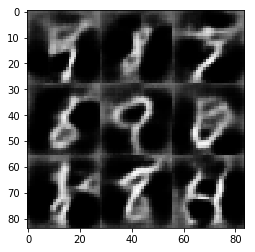

Epoch 2/2... Discriminator Loss: 1.2880... Generator Loss: 0.8138
Epoch 2/2... Discriminator Loss: 1.3123... Generator Loss: 0.8298
Epoch 2/2... Discriminator Loss: 1.2520... Generator Loss: 0.8827
Epoch 2/2... Discriminator Loss: 1.2959... Generator Loss: 0.9046
Epoch 2/2... Discriminator Loss: 1.2839... Generator Loss: 0.8332
Epoch 2/2... Discriminator Loss: 1.3065... Generator Loss: 0.9689
Epoch 2/2... Discriminator Loss: 1.2940... Generator Loss: 0.9048
Epoch 2/2... Discriminator Loss: 1.2817... Generator Loss: 0.8537
Epoch 2/2... Discriminator Loss: 1.3308... Generator Loss: 0.8075
Epoch 2/2... Discriminator Loss: 1.2645... Generator Loss: 0.8035


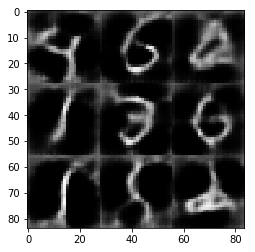

Epoch 2/2... Discriminator Loss: 1.2377... Generator Loss: 0.8926
Epoch 2/2... Discriminator Loss: 1.3681... Generator Loss: 0.9031
Epoch 2/2... Discriminator Loss: 1.3299... Generator Loss: 0.7720
Epoch 2/2... Discriminator Loss: 1.2740... Generator Loss: 0.8334
Epoch 2/2... Discriminator Loss: 1.2773... Generator Loss: 0.8197
Epoch 2/2... Discriminator Loss: 1.4070... Generator Loss: 0.6835
Epoch 2/2... Discriminator Loss: 1.3047... Generator Loss: 0.8034
Epoch 2/2... Discriminator Loss: 1.2616... Generator Loss: 0.8452
Epoch 2/2... Discriminator Loss: 1.3188... Generator Loss: 0.8492
Epoch 2/2... Discriminator Loss: 1.2852... Generator Loss: 0.9210


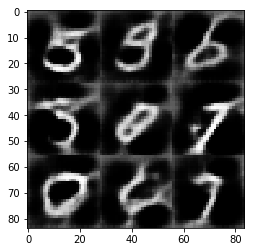

Epoch 2/2... Discriminator Loss: 1.2583... Generator Loss: 0.9584
Epoch 2/2... Discriminator Loss: 1.3396... Generator Loss: 0.8694
Epoch 2/2... Discriminator Loss: 1.2836... Generator Loss: 0.8662
Epoch 2/2... Discriminator Loss: 1.4485... Generator Loss: 0.8485
Epoch 2/2... Discriminator Loss: 1.3088... Generator Loss: 0.8502
Epoch 2/2... Discriminator Loss: 1.3399... Generator Loss: 0.8081
Epoch 2/2... Discriminator Loss: 1.2022... Generator Loss: 1.0306
Epoch 2/2... Discriminator Loss: 1.2830... Generator Loss: 0.7855
Epoch 2/2... Discriminator Loss: 1.2524... Generator Loss: 0.8266
Epoch 2/2... Discriminator Loss: 1.3932... Generator Loss: 0.9487


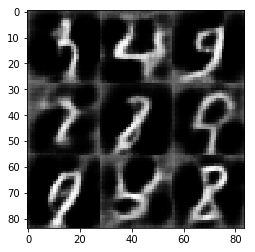

Epoch 2/2... Discriminator Loss: 1.3750... Generator Loss: 0.7500
Epoch 2/2... Discriminator Loss: 1.3058... Generator Loss: 1.1707
Epoch 2/2... Discriminator Loss: 1.2486... Generator Loss: 0.8459
Epoch 2/2... Discriminator Loss: 1.1708... Generator Loss: 0.9559
Epoch 2/2... Discriminator Loss: 1.2847... Generator Loss: 0.9009
Epoch 2/2... Discriminator Loss: 1.3254... Generator Loss: 0.8321
Epoch 2/2... Discriminator Loss: 1.3577... Generator Loss: 0.8499
Epoch 2/2... Discriminator Loss: 1.5760... Generator Loss: 0.7028
Epoch 2/2... Discriminator Loss: 1.2833... Generator Loss: 1.0029
Epoch 2/2... Discriminator Loss: 1.2751... Generator Loss: 0.8999


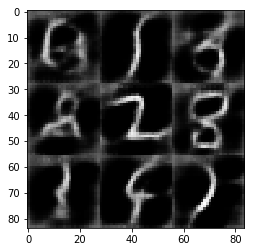

Epoch 2/2... Discriminator Loss: 1.1944... Generator Loss: 0.9545
Epoch 2/2... Discriminator Loss: 1.4354... Generator Loss: 0.7437
Epoch 2/2... Discriminator Loss: 1.3938... Generator Loss: 0.6672
State of the art after epoch 2


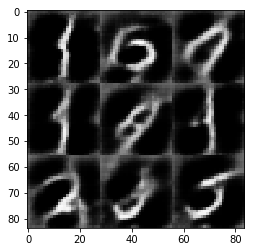

In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 1.2477
Epoch 1/1... Discriminator Loss: 1.5556... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.5151... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.5711... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.8219


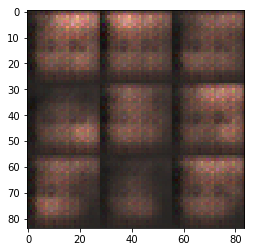

Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.8540
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 0.8601


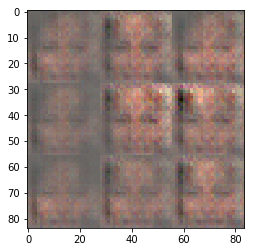

Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.8761
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.5047... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.9221


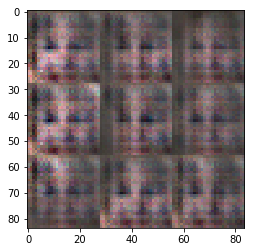

Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.9821
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 1.1917
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 1.2546
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 1.1142
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.7985


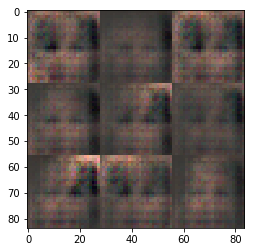

Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.8030


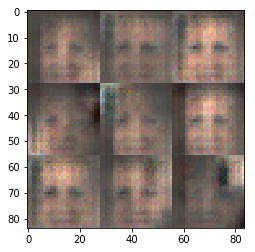

Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.8740


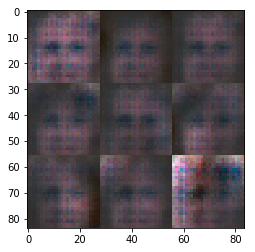

Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.3470... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.7755


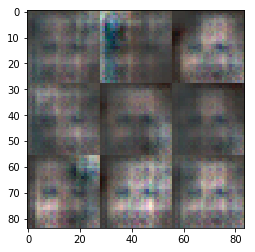

Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.9442
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.8452


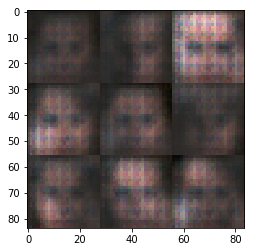

Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.8563


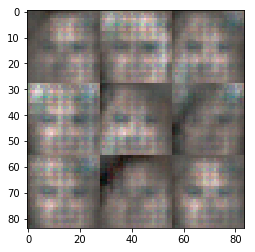

Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.9631
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 1.1864
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 1.0465


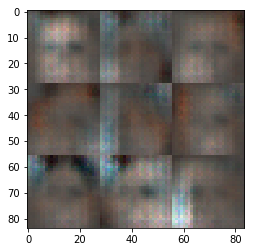

Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 1.3126
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 1.1418
Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 1.2758
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.8696


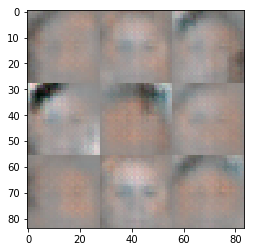

Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.9004
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 0.9603


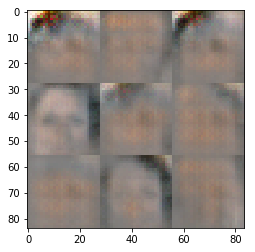

Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.9628
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7866


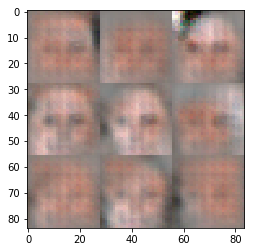

Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.9265
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.4726
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 1.0133
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.8275


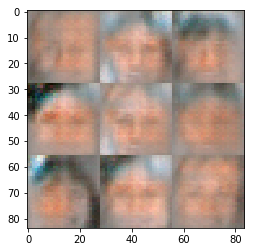

Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 1.4235
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 0.8125
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 1.1175
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8579


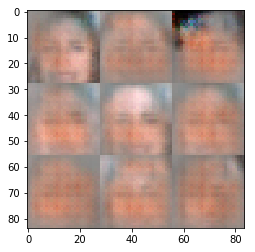

Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 1.0674
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 1.1331
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.8958
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.9384
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.9930


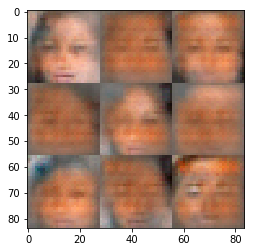

Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.9670
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.9088


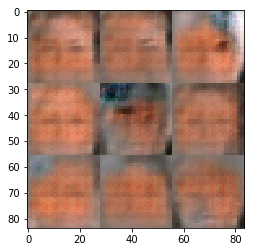

Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.9398
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 1.1016
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 1.3796
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.9746
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.9031


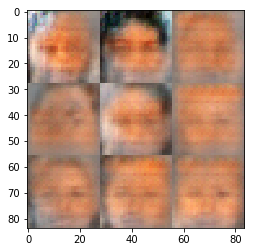

Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 1.0105
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 1.0342


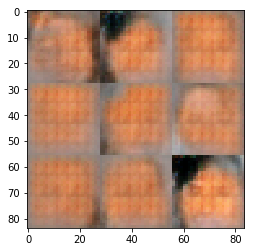

Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.9503
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8054


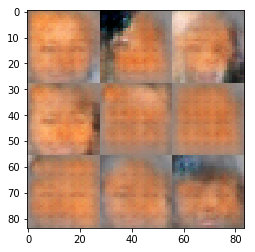

Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 1.0809
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 1.0389
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 1.1067
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.9169


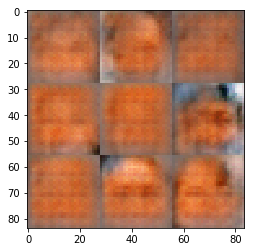

Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.9633
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 1.0144
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 1.0629
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 1.0416


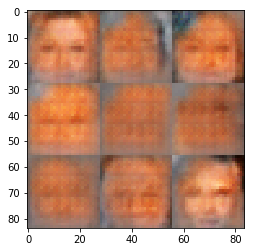

Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 1.0047
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.9613
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.9666


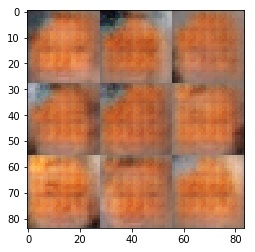

Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 1.1672
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.8532


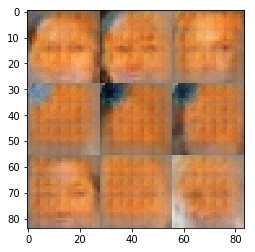

Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 1.1088
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 1.0088
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.9512


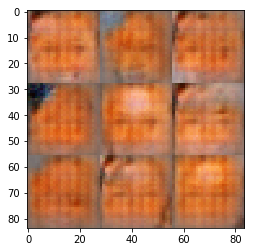

Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 1.0402
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.9661
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 1.0015
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.9936


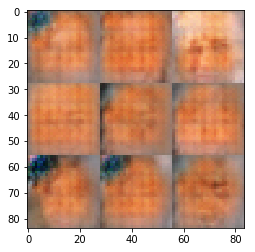

Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.8755
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.9677
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 1.0308
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.7664


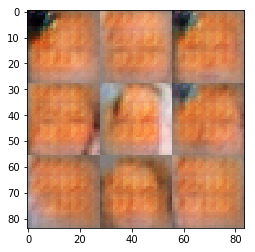

Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.9918
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 1.0400


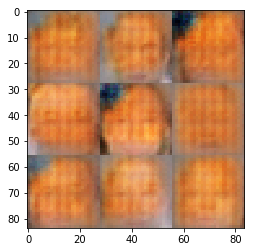

Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.9521
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.9262
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.9881


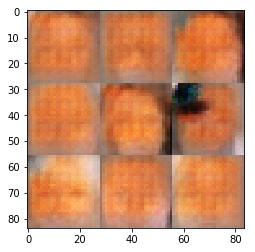

Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 1.0125
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.9096
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.8210


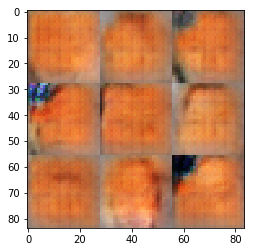

Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.8607
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.8147


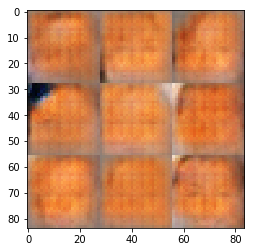

Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 1.0291
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.9665
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.8094
State of the art after epoch 1


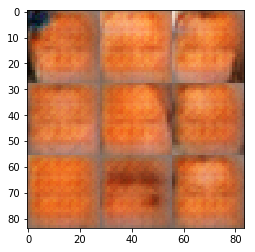

In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.